Learning Tensorflow usage for NLP by running a sentiment analysis on IMDB reviews

Many of the exercises (and some snippets of code) in this notebook follow from Chapter 6 of Deep Learning with Python -- excellent book

Data: imdb sentiment set in CSV form

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
 
# First, here are some useful functions for checking out the dataset and plotting training, validation accuracy, etc. We  load these first and then get onto the interesting part
 
def dsInfo(ds):
    print(ds.head(10)) # checkout the first 10 rows of the dataset
    print("Dataset shape: ")
    print(ds.shape)

    
# plot some results -- training loss, validation loss
def plotResults(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1,len(acc)+1) # time axis

    ms = 8
    lw = 2
    fs = 20

    fig,axs = plt.subplots(2,1,sharex=True,figsize=(8,8))
    axs[0].plot(epochs,acc,'ko',markersize=ms,label="Training")
    axs[0].plot(epochs,val_acc,'ko-',markersize=ms,linewidth=lw,label="Validation")
    axs[0].set_xlabel("Epoch",fontsize=fs)
    axs[0].set_ylabel("Accuracy",fontsize=fs)

    axs[1].plot(epochs,loss,'ko',markersize=ms)
    axs[1].plot(epochs,val_loss,'ko-',markersize=ms,linewidth=lw)
    axs[1].set_xlabel("Epoch",fontsize=fs)
    axs[1].set_ylabel("Loss",fontsize=fs)

    axs[0].tick_params(axis="y",labelsize=14)
    axs[0].tick_params(axis="x",labelsize=14)
    axs[1].tick_params(axis="y",labelsize=14)
    axs[1].tick_params(axis="x",labelsize=14)

    fig.legend(prop={'size': 18.0},loc="upper center",ncol=2)    
    # plt.tight_layout()
    plt.show()
    


Let's first load the dataset into a dataframe and then check it out using dsInfo function created above

In [3]:
# load in dataset into Pandas dataframe

imdb_train = pd.read_csv("IMDB_Dataset.csv",names = ['review','sentiment'])

# get some basic info on this dataset by calling dsInfo function
dsInfo(imdb_train)

                                              review  sentiment
0                                             review  sentiment
1  One of the other reviewers has mentioned that ...   positive
2  A wonderful little production. <br /><br />The...   positive
3  I thought this was a wonderful way to spend ti...   positive
4  Basically there's a family where a little boy ...   negative
5  Petter Mattei's "Love in the Time of Money" is...   positive
6  Probably my all-time favorite movie, a story o...   positive
7  I sure would like to see a resurrection of a u...   positive
8  This show was an amazing, fresh & innovative i...   negative
9  Encouraged by the positive comments about this...   negative
Dataset shape: 
(50001, 2)


We see there are 50,000 reviews separated into two columns: 1) the review itself and 2) whether it's a positive or negative sentiment. 

Let's prep this data by tokenizing the text and splitting it into training, validation, and testing samples

In [4]:
# function that tokenizes the text part, keeps only certain words per review, etc.
# Inputs: training_samples, validation_samples...max_words = # of words total, maxlen = # of words per review
def prepData(ds,training_samples, validation_samples, max_words, maxlen):
    # separate the text reviews from the labels
    texts = ds['review']
    labels = []

    # convert sentiment to 0s and 1s
    for sent in ds['sentiment']:
        if (sent=='positive'):
            labels.append(1)
        else:
            labels.append(0)

    # tokenize the text part

    tokenizer=Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)

    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print("Number of unique tokens: %s " % len(word_index))

    data = pad_sequences(sequences,maxlen=maxlen)
    labels = np.asarray(labels)

    indices = np.arange(data.shape[0])
    np.random.shuffle(indices) # shuffle dataset because it could be ordered in a biased way

    data = data[indices]
    labels = labels[indices]

    # split into training, validation and test sets
    validation_sample_index = training_samples + validation_samples

    x_train, y_train = data[:training_samples], labels[:training_samples]
    x_val, y_val = data[training_samples:validation_sample_index], labels[training_samples:validation_sample_index]
    x_test, y_test = data[validation_sample_index:], labels[validation_sample_index:]

    return x_train, y_train, x_val, y_val, x_test, y_test 


In [5]:
# number of training samples and validation samples
training_samples = 5000
validation_samples = 5000
 
# max number of features and max number of words per review
max_words = 10000 # number of words
maxlen = 50 # number of words per review
 
x_train, y_train, x_val, y_val, x_test, y_test = prepData(imdb_train, training_samples, validation_samples, max_words,    maxlen)


Number of unique tokens: 124252 


Now we can create various models and test them

In terms of neural networks, the easiest model is one with an Embedding layer followed by a single Dense layer. As shown in Deep Learning with Python, this only works "ok"

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 50, 8)             80000     
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 401       
                                                                 
Total params: 80,401
Trainable params: 80,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
157/157 [==============================] - 1s 3ms/step - loss: 0.6923 - acc: 0.5194 - val_loss: 0.6908 - val_acc: 0.5436
Epoch 2/10
157/157 [==============================] - 0s 2ms/step - loss: 0.6714 - acc: 0.7336 - val_loss: 0.6810 - val_acc: 0.6004
Epoch 3/10
157/157 [==============================

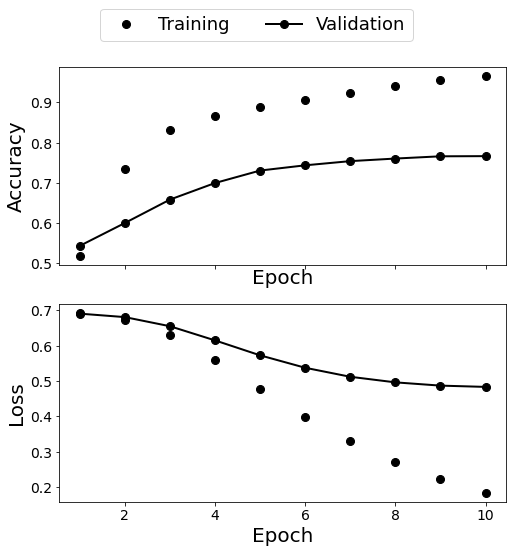

In [8]:
# Easiest function that creates an Embedding layer and uses a classifier
# trains a single Dense layer
 
model = Sequential()

model.add(Embedding(max_words, 8, input_length = maxlen))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid')) # one dense layer with sigmoid activation (classifier)

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()

history = model.fit(x_train,y_train,epochs=10,batch_size=32,validation_data = (x_val, y_val))

# plot the training and validation accuracy, loss
plotResults(history)

# To analyze results, we can also use the TensorFlow Board, but that's for another day...

Next model that one *could* try is a recurrent neural network with LSTM (long short term memory). However, sentiment analysis is unlikely to benefit from this (at least a simple unidirectional RNN, i.e. simpleRNN). RNNs and LSTM are better for applications where we want to analyze the long-term structure of a review. Here, we care more about the frequency of words like "good" vs "bad". RNNs are also computationally expensive...
 

But let's at least see what happens if we try a *bidirectional* RNN, which means we supplement the original set of reviews with their chronological  inverses -- i.e. reading the reviews backwards. This *should* give decent results, because again, the order and structure of these  reviews doesn't mean as much as the occurrence of key words.

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          320000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
40/40 [==============================] - 5s 47ms/step - loss: 0.6518 - acc: 0.5940 - val_loss: 0.5488 - val_acc: 0.7258
Epoch 2/10
40/40 [==============================] - 1s 30ms/step - loss: 0.4102 - acc: 0.8158 - val_loss: 0.6336 - 

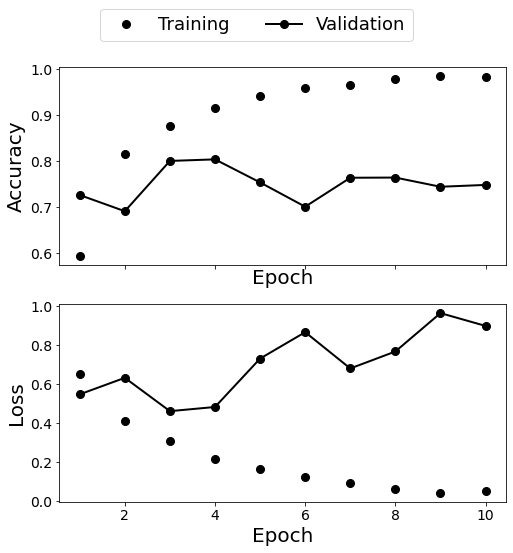

In [11]:
model = Sequential()
model.add(Embedding(max_words,32))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()
 
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_data = (x_val, y_val)) 

# plot the training and validation accuracy, loss
plotResults(history)

This doesn't do too bad! It slightly increases the validation accuracy, but it overfits really early. Let's try some regularization to see what accuracy we can achieve...

Number of unique tokens: 124252 
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, None, 32)          320000    
                                                                 
 dropout_2 (Dropout)         (None, None, 32)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
______________

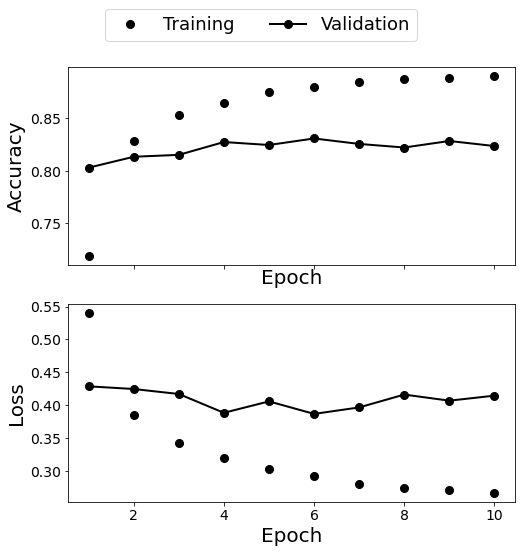

In [16]:
# Same bidirectional RNN but with some regularization, in this case just a simple dropout layer before the Dense layer
# To help with overfitting, we also use a larger set of training data (because we have it available)
# number of training samples and validation samples
training_samples = 25000
validation_samples = 5000
 
# max number of features and max number of words per review
max_words = 10000 # number of words
maxlen = 50 # number of words per review
 
x_train, y_train, x_val, y_val, x_test, y_test = prepData(imdb_train, training_samples, validation_samples, max_words,    maxlen)



from keras.layers import Dropout

model = Sequential()
model.add(Embedding(max_words,32))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
model.summary()
 
history = model.fit(x_train,y_train,epochs=10,batch_size=128,validation_data = (x_val, y_val)) 

# plot the training and validation accuracy, loss
plotResults(history)

The model definitely benefits from a larger training set (and somewhat from the two dropout layers), now reaching 80-85% validation accuracy. 

Next up we'll try a convolutional neural network